# Machine Learning Project 2

In [1]:
# Imports
import pandas as pd
import numpy as np

In [2]:
# Base parameters

# Loading
embeddings_file = 'embeddings_full.npy'
vocab_file = 'vocab_cut.txt'

# Training
local_t_size = 100_000
word_vectors_file_location = '../precomputed_data/'
embeddings_dim_info = 20

---
## Data Loading

In this section we load the data for :
* positive tweets, label= `:)` ($1$ for classification) 
* negative tweets, label= `:(` ($-1$ for classification)

Full data is used below (1'250'000 tweets).

In [3]:
data_path = '../data/'

## Load full training sets
# positive
pos = pd.read_table(data_path+'train_pos_full.txt', sep='.\n', names=['tweet'], engine='python')
pos['label']=1
print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==1_250_000}")

# negative
neg = pd.read_table(data_path+'train_neg_full.txt', sep='.\n', names=['tweet'], engine='python')
neg['label']=-1
print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==1_250_000}")

# Data sizes
print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

# Merge datasets to get a complete training set
tweets = pos.append(neg)
tweets

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000



,tweet,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
1249995,im so sorry ! <user> & to <user> & <user> u gu...,-1
1249996,i can't find food coloring anywhere,-1
1249997,<user> same here ! ! but tort ! ! wonder why y...,-1
1249998,keyless entry remote fob clicker for 2005 buic...,-1


In [4]:
## Load word embeddings and vocabulary to compute word vectors of tweets

# Load word embeddings
embeddings = np.load(data_path + embeddings_file)
print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

# Loading vocab
words = pd.read_table(data_path + vocab_file, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
print(f'Loaded word embeddings in structure of type {type(words)}.')

# Check that the vocabulary encompasses all embedded words
print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

## Clean the data

# Drop NaN values in words
nas = words.isna()
words.dropna(inplace=True)
embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
print(f'NA values were dropped in both tables: {len(embeddings)==words.shape[0]}')
print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

# Index by words for faster index-for-word search
words = pd.DataFrame(data=words.index, index=words.values)
embeddings = pd.DataFrame(embeddings, index=words.index)

Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word embeddings in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 20), vocab: (101298,)
NA values were dropped in both tables: True
Embeddings: (101296, 20), vocab: (101296,)


In [5]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
<user>,0.000327,0.028452,0.016525,0.000613,0.005188,-0.002815,0.009533,-0.044277,0.009413,0.031187,0.010009,-0.002514,0.007920,0.036842,-0.012512,0.022829,-0.000567,-0.016734,-0.008299,-0.008789
!,-0.019161,0.027524,0.033832,0.012091,-0.027132,-0.012628,-0.000841,-0.033120,0.013693,-0.004513,0.016704,0.015588,-0.008836,0.035705,0.007875,0.015618,0.009505,-0.011820,-0.003584,-0.005041
i,0.019321,0.030986,0.014057,0.007218,-0.002602,-0.022695,-0.004233,-0.033344,-0.001470,0.013007,0.002135,-0.007511,0.003676,0.010762,-0.002978,-0.001809,0.010544,-0.023608,-0.014181,-0.004194
the,0.002400,0.021290,0.007768,-0.005454,-0.016949,-0.001816,-0.008950,-0.037330,-0.029912,-0.008472,0.005187,-0.016195,0.006317,-0.010477,-0.022874,-0.001610,-0.006108,-0.008685,-0.011349,0.006130
.,-0.002507,0.011608,0.027699,0.013425,-0.020171,0.008285,-0.012358,-0.045863,-0.002258,0.031533,-0.014051,0.008234,0.008522,0.012892,0.017243,-0.006924,0.004531,-0.021841,-0.005605,-0.022420


In [6]:
words.head()

,0
<user>,0
!,1
i,2
the,3
.,4


---
## Exploratory Data Analysis
In this part we analyse our data in order to optimize its information.

### Cleaning tags 
Here we explore the non-spoken tags present in the tweets and determine if they are relevant for our sentiment analysis.

In [7]:
import re
from collections import defaultdict

## We check if the tags are relevant information between both pos and neg cases

def count_HTML_tags(series) :
    """
    Returns stats about the HTML tags in the tweet series.
    Returns :
    dic (defaultdict) : dict of all tags occurences.
    count (int) : count of all tags."""
    dic = defaultdict(lambda:0)
    def a(k):
        dic[k]+=1
        return None
    series.apply(lambda s : [a(k) for k in re.findall('<\/*[a-zA-Z]+>', s)])
    count = series.str.count('<\/*[a-zA-Z]+>').sum()
    return dic, count

# We query stats about the tags
d_pos, n_pos = count_HTML_tags(pos['tweet'])
d_neg, n_neg = count_HTML_tags(neg['tweet'])
all_keys = set(d_pos.keys()) | set(d_neg.keys())

print(f"|{'KEY':14s}|{'POS':6s}|{'NEG':6s}|")
for k in all_keys : 
    print(f"|{k:14s}|{d_pos[k]:6d}|{d_neg[k]:6d}|")

print(f"\nPOS tweets contain {n_pos} ({(n_pos-n_neg)*100/n_neg:.2f}%) HTML tags.")
print(f"NEG tweets contain {n_neg} ({(n_neg-n_pos)*100/n_pos:.2f}%) HTML tags.")

|KEY           |POS   |NEG   |
|<gardenstuff> |     2|     0|
|<likewise>    |     1|     0|
|<brr>         |     1|     0|
|<ducks>       |     1|     0|
|<c>           |     1|     2|
|<strong>      |     0|     6|
|<mournfully>  |     0|     1|
|</html>       |     0|     1|
|</i>          |     0|    11|
|<emotional>   |     0|     1|
|<hot>         |     1|     0|
|<calc>        |     1|     0|
|<hugs>        |     1|     1|
|<ht>          |     0|     1|
|<sarah>       |     1|     0|
|<thing>       |     0|     1|
|<twinkle>     |     0|     1|
|</summary>    |     1|     0|
|</b>          |     1|    19|
|<laugh>       |     1|     0|
|<syrian>      |     0|     6|
|</strong>     |     0|     6|
|<agent>       |     0|     3|
|<screams>     |     0|     1|
|<space>       |     3|     0|
|<url>         | 98886|427976|
|<weirdarms>   |     1|     0|
|<p>           |     0|    16|
|</cfoutput>   |     0|     1|
|<impressive>  |     1|     0|
|</script>     |     0|     4|
|</body>

**Note**: Although the difference in number of tags is not significant. The distribution of them is quite significant (i.e. for tags `<url>` and `<user>`). Thus we choose to leave the tags as part of the tweet. **THIS COULD BE REVIEWED TO IMPROVE PERF**

In [8]:
# Clean the HTML tags from the tweets
## CHANGE RETURN VAR IF RELEVANT

def clean_HTML_tags(series) :
    return series.str.replace('<\/*[a-zA-Z]+>', '', regex=True)

t = clean_HTML_tags(pos['tweet'])
t2 = clean_HTML_tags(neg['tweet'])

---
## Training
In this part we train the models on our data.
Thus, we perform
* a resampling of our data to work locally on a smaller set.
* the creation of word vectors for our tweets.
* a train-test-split to locally estimate the model's performance.
* cross-validation trainin on a series of models :
    * Linear Regression
    * Logistic Regression
    * SVM
    * Neural Networks

### Resampling the Training set
Using only a set of 200'000 tweets locally to decrease computation time.

In [9]:
from sklearn.utils import resample

# Take only `0.5*local_t_size` samples from both classes for faster computation
n = int(local_t_size/2)
pos_ = resample(pos, n_samples=n, replace=False)
neg_ = resample(neg, n_samples=n, replace=False)
tweets_ = pos_.append(neg_)

tweets_

,tweet,label
97921,<user> <user> <user> i have to watch last nigh...,1
76238,<user> sorry haha how's the coughdrops ?,1
1103757,nuh kno why them stop air this inu .. ting sii...,1
313723,<user> auuu gucci to knw i'm doing well thnks ...,1
313200,"<user> naw , i'm still in sf ! i know right ? ...",1
...,...,...
540029,"kwaaa ... waelese ya koloi rt "" <user> tape ? ...",-1
286229,huge drop in prices hp dm842a laptop battery (...,-1
807871,<user> just because i'm a cripple ! was in a c...,-1
365434,don't know much about the solar system ( paper...,-1


### Word vectors creation

In [10]:
# Recall our data
print(f"Embeddings for {embeddings.shape[0]:,.1f} with {embeddings.shape[1]} features for each word.") 
print(f'Embeddings shape : {embeddings.shape}.\n')
embeddings.head(2)

Embeddings for 101,296.0 with 20 features for each word.
Embeddings shape : (101296, 20).



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
<user>,0.000327,0.028452,0.016525,0.000613,0.005188,-0.002815,0.009533,-0.044277,0.009413,0.031187,0.010009,-0.002514,0.007920,0.036842,-0.012512,0.022829,-0.000567,-0.016734,-0.008299,-0.008789
!,-0.019161,0.027524,0.033832,0.012091,-0.027132,-0.012628,-0.000841,-0.033120,0.013693,-0.004513,0.016704,0.015588,-0.008836,0.035705,0.007875,0.015618,0.009505,-0.011820,-0.003584,-0.005041


In [11]:
def word_vector(tweet):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get vocab word embeddings
    for w in split_by_words:
        if w in words.index :
            embed_list.append(  embeddings.loc[w].values  )
        
    # Compute mean if any vocab word was found
    mean = np.zeros(embeddings_dim_info) if not embed_list else np.mean(embed_list, axis=0) 
    return mean.tolist()

In [12]:
import numpy as np
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
 
def parallelize(data, func):
    """
    Uses all CPU cores available to compute the function on each element of the data.
    """
    print(f"Computing function on {cores} cores.")
    data_split = np.array_split(data, partitions)
    print(data_split)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

import ctypes, os
# Checking if the process is executed as admin (multiprocessing does not work otherwise) 
def isAdmin():
    """
    Verifies if the process is executed as administrator.
    """
    try:
        is_admin = (os.getuid() == 0)
    except AttributeError:
        is_admin = ctypes.windll.shell32.IsUserAnAdmin() != 0
    return is_admin

In [13]:
%%time
from pandas.errors import MergeError

try :
    # Load pre-computed word vectors file if possible 
    name = word_vectors_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'.npy'
    print(f"Trying to load word vectors from {name}")
    precomputed = np.load(name, allow_pickle=True)
    
    # Transform into Dataframe for merge
    precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
    pos_ = pos.loc[precomputed.loc[precomputed['label']==1, 'index']]
    neg_ = neg.loc[precomputed.loc[precomputed['label']==-1, 'index']]
    tweets_ = pos_.append(neg_).reset_index()
    tweets_ = tweets_.merge(precomputed, how='inner', on=['index', 'label'], validate='1:1').set_index('index')
    print('Successfully loaded from file!')
    
except (FileNotFoundError) as e :
    # Create word vectors for the local dataset
    
    print('Could not load word vectors from file...\nRecomputing word vectors...')
    if isAdmin():
        print('Process is run as admin. Running parallelized computation...')
        tweets_['mean_embed']= parallelize(tweets_['tweet'], word_vector)
    else : 
        print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
        tweets_['mean_embed']= tweets_['tweet'].map(word_vector)

Trying to load word vectors from ../precomputed_data/word_vectors_100000_20.npy
Successfully loaded from file!
Wall time: 706 ms


In [14]:
tweets_

,tweet,label,mean_embed
index,,,
1020761,<user> kus niggas tryna find new ways to get f...,1,"[0.006111815659464072, 0.7197322757532972, -0...."
690958,joanna symons suggests how to find accommodati...,1,"[-0.017124226010274895, 0.4027337962952229, 0...."
656365,<user> what time ?,1,"[0.06875733450303735, 0.5183489266332838, 0.04..."
384680,<user> it was the right tweet son,1,"[0.09417493947047391, 0.5709764570942454, 0.04..."
393805,i wanna go . rt <user> finna go go buffalo wil...,1,"[0.10825893930221646, 0.5741484203775674, 0.20..."
...,...,...,...
210752,"novica blown wine glasses , ' crimson serpenti...",-1,"[0.06386397143353187, 0.5318056923844712, -0.0..."
97104,walthers ho scale hs #902074 ttwx all purpose ...,-1,"[0.09309077043951619, 0.5157496136248376, 0.12..."
975497,<--- ain't had sex in a long time . i'm gonna ...,-1,"[0.09434767776236758, 0.6438721760825019, 0.05..."


In [15]:
# Save word vectors file to gain time
word_vectors = tweets_[['label', 'mean_embed']].reset_index()
name = word_vectors_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)

np.save(name, word_vectors)

### Train-Test Split for our local dataset
We divide our local training set into a 75% training set and a 25% local testing set.

In [16]:
from sklearn.model_selection import train_test_split

train_, test_ = train_test_split(tweets_, test_size=0.25)
print(f"Local training set size : {train_.shape}.")
print(f"Local testing set size : {test_.shape}.")

Local training set size : (75000, 3).
Local testing set size : (25000, 3).


In [17]:
# Create features and label datasets
xtrain_, ytrain_ = train_.mean_embed.copy().tolist(), train_.label.copy().to_list()
xtest_, ytest_ = test_.mean_embed.copy().tolist(), test_.label.copy().tolist()

xtest_[:1]

[[0.0632350195270927,
  0.5748488565393931,
  0.1361312402257324,
  0.1915610410484348,
  -0.10095502228794752,
  -0.11168217756042016,
  -0.025474462111906893,
  -0.17857724104200398,
  -0.09355545091102035,
  -0.07920785306372477,
  0.015301681114033567,
  0.2472566944964623,
  -0.051691980933392556,
  0.004224113296379121,
  -0.022270074228796486,
  -0.08313194894481984,
  0.03771670071775033,
  -0.0823542405450677,
  -0.32079095392438234,
  0.2435019561824692]]

### Pre-Processing
Here we compute our pre-processing on features.

Starting to plot...


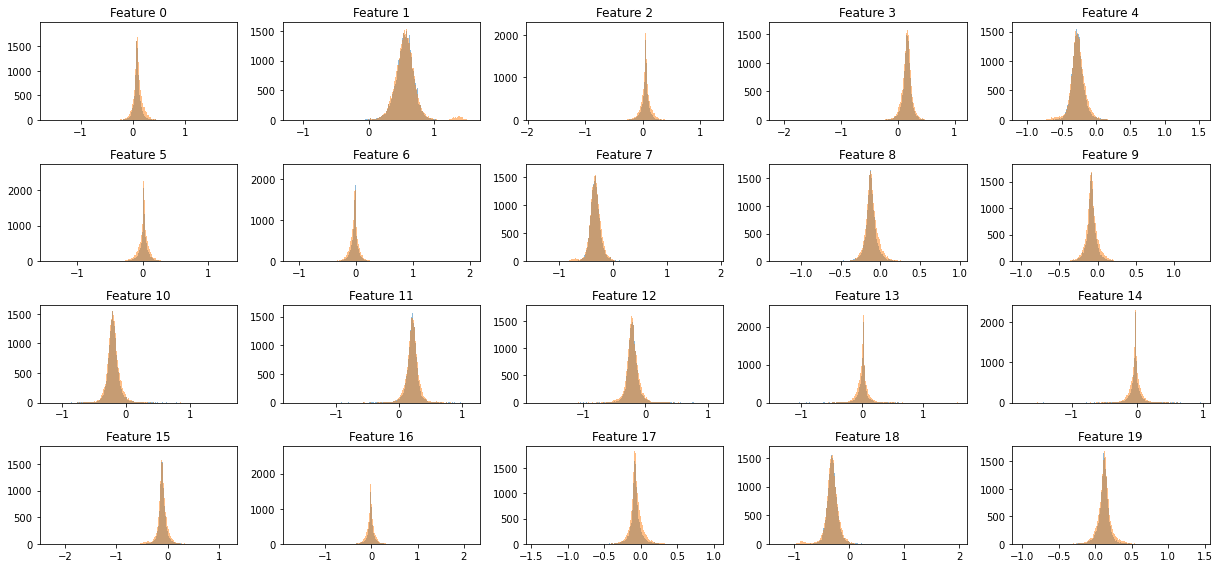

In [38]:
xtrain_ = np.array(xtrain_)

ny = 5
nx = int(xtrain_.shape[1]/ny)
nx_r = xtrain_.shape[1]%ny
nx = nx if nx_r == 0 else nx+1

fig, axes = plt.subplots(nx, ny, figsize=(17,8))
print(f"Starting to plot...")
for i, a in enumerate(axes.flatten()) :
    p = np.array(tweets_.loc[tweets_.label==1, 'mean_embed'].tolist())[:,i]
    n = np.array(tweets_.loc[tweets_.label==-1, 'mean_embed'].tolist())[:,i]

    a.hist(p, bins='auto', alpha=0.5)
    a.hist(n, bins='auto', alpha=0.5)
    a.set_title(f'Feature {i}')

plt.tight_layout()
plt.show()